In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

In [3]:
# Model is roberta-base, zero-shot and few-shot hybrid
datasets = {"agnews": 1, "yahoo": 1} # "mnli": 0, "yelp-full": 0
all_client_num_in_total_list = {"agnews": 1000, "yahoo": 1000, "yelp-full": 1000, "mnli": 1000}
alphas = {"agnews": 1, "yahoo": 1, "yelp-full": 0, "mnli": 0}
gammas = {"agnews": 0.001, "yahoo": 0.001, "yelp-full": 100, "mnli": 100}
full_set_acc= {"agnews": 0.93, "yahoo": 0.78, "yelp-full": 0.7, "mnli": 0.85}
train_data = {"agnews": 0, "yahoo": 64}


labels = []
k_list = [1,2,4,8] # data point
n_list = [5,10,15,20] # infer client num
f_list = [1,2,4] # infer frequency


seed = 42

# source file/log
root_path = "/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/"
output_fig_path = "/Users/cdq/Desktop/opensource/FedPrompt/figs/pacing"

# plot hyper-para.
colors=['r','g','b','y','c','m','k'] * 100

train_latency_list = {"tx2+bitfit": 1, "tx2+full": 2}
infer_latency_list = {"tx2+bitfit": 0.5, "tx2+full": 1}
communication_latency_list = {"bitfit": 1000 * 2 / 1000 / 1, "full": 1000 * 2 / 1}

/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/agnews/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_1_conver_0_limit_0_fedpet_0_32_roberta-base_5_1.log
max accuracy is 0.8656578947368421, round is 26
['k=1, n=5, f=1', 'k=1, n=5, f=2', 'k=1, n=5, f=4', 'k=1, n=10, f=1', 'k=1, n=10, f=2', 'k=1, n=10, f=4', 'k=1, n=15, f=1', 'k=1, n=15, f=2', 'k=1, n=15, f=4', 'k=1, n=20, f=1', 'k=1, n=20, f=2', 'k=1, n=20, f=4', 'k=2, n=5, f=1', 'k=2, n=5, f=2', 'k=2, n=5, f=4', 'k=2, n=10, f=1', 'k=2, n=10, f=2', 'k=2, n=10, f=4', 'k=2, n=15, f=1', 'k=2, n=15, f=2', 'k=2, n=15, f=4', 'k=2, n=20, f=1', 'k=2, n=20, f=2', 'k=2, n=20, f=4', 'k=4, n=5, f=1', 'k=4, n=5, f=2', 'k=4, n=5, f=4', 'k=4, n=10, f=1', 'k=4, n=10, f=2', 'k=4, n=10, f=4', 'k=4, n=15, f=1', 'k=4, n=15, f=2', 'k=4, n=15, f=4', 'k=4, n=20, f=1', 'k=4, n=20, f=2', 'k=4, n=20, f=4', 'k=8, n=5, f=1', 'k=8, n=5, f=2', 'k=8, n=5, f=4', 'k=8, n=10, f=1', 'k=8, n=10, f=2', 'k=8, n=10, f=4', 'k=8, n=15, f=1', 'k

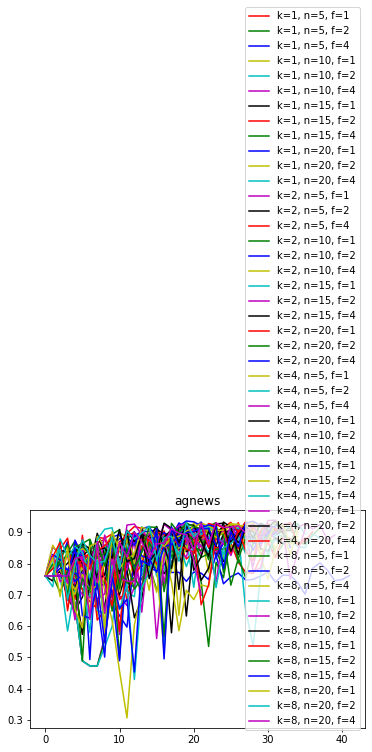

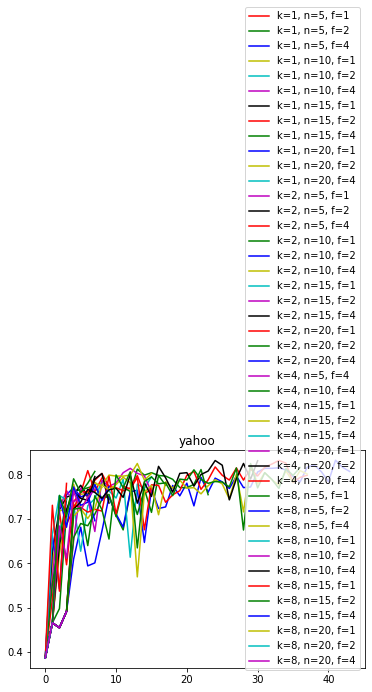

In [4]:
# round to accuracy
i=0
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
round_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
for dataset in datasets:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = []
    labels = []
    for k in k_list:
        for n in n_list:
            for f in f_list:
                filenames.append(f"new_all_aug_{k}_conver_0_limit_0_fedpet_{train_data[dataset]}_32_roberta-base_{n}_{f}.log")
                labels.append(f"k={k}, n={n}, f={f}")
                
    fig = plt.figure()
    plt.title(dataset)

    for filename in filenames:
            
        log_path = os.path.join(log_root_path, filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue


        # plt.title(log_path)
        iter = 1000
        phrase = 'aggregated model performance is'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        for line in f:
            if phrase in line:
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")
            continue

        # print(filename)
        # print(df)
        this_max_acc = np.max(df[0])
        idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
        print(log_path)
        print(f"max accuracy is {this_max_acc}, round is {idx}")
        acc_list[dataset].append(this_max_acc)
        round_list[dataset].append(idx)
        # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
        iter = len(df.index)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(labels, filenames.index(filename))
        print(range(iter))
        print(np.array(y_mean)/full_set_acc[dataset])
        print(colors[filenames.index(filename)])
        print(labels[filenames.index(filename)])
        plt.plot(range(iter),np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)])
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.1),bbox_transform=fig.transFigure)
    fig.savefig(os.path.join(output_fig_path, f"a{i}.pdf"))
    i = i+1

/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/agnews/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_1_conver_0_limit_0_fedpet_0_32_roberta-base_5_1.log
max accuracy is 0.8656578947368421, runtime is 1949.0
32 32
/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/agnews/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_1_conver_0_limit_0_fedpet_0_32_roberta-base_5_2.log
max accuracy is 0.8606578947368421, runtime is 1179.0
39 38
/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/agnews/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_1_conver_0_limit_0_fedpet_0_32_roberta-base_5_4.log
max accuracy is 0.7690789473684211, runtime is 388.0
42 42
/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/agnews/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_1_conver_0_limit_0_fedpet_0_32_roberta-base_10_1.log
max accuracy is 0.8588157894736842, runtime is 1856.0
28 28
/Users/cdq/D

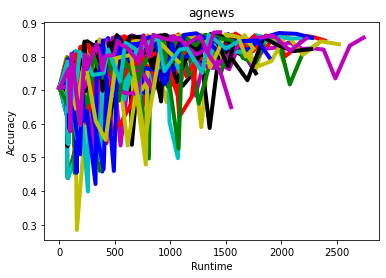

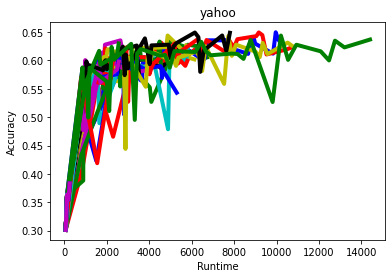

In [5]:
# time to accuracy  
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}     
for dataset in datasets:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = []
    labels = []
    for k in k_list:
        for n in n_list:
            for f in f_list:
                filenames.append(f"new_all_aug_{k}_conver_0_limit_0_fedpet_{train_data[dataset]}_32_roberta-base_{n}_{f}.log")
                labels.append(f"k={k}, n={n}, f={f}")
                
    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Runtime")
    plt.ylabel("Accuracy")
    for filename in filenames:

        log_path = os.path.join(log_root_path, filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        runtime = []
        train_runtime = []
        infer_runtime = []
        time_stamp = 0
        train_time_stamp = 0
        infer_time_stamp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                train_samples = list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]
                infer_samples = list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]

                # TX2: train, 1s/sample, infer, 0.5s/sample.
                train_time = np.max(train_samples) * train_latency_list["tx2+bitfit"] if len(train_samples) > 0 else 0
                infer_time = np.max(infer_samples) * infer_latency_list["tx2+bitfit"] if len(infer_samples) > 0 else 0
                
                comm_time = communication_latency_list["bitfit"]

                time_stamp = time_stamp + train_time + infer_time + comm_time# elasped time of all clients / energy consumption
                train_time_stamp = train_time + train_time_stamp
                infer_time_stamp = infer_time + infer_time_stamp
                runtime.append(time_stamp)
                train_runtime.append(train_time_stamp)
                infer_runtime.append(infer_time_stamp)
            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")

        this_max_acc = np.max(df[0])
        idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
        print(log_path)
        print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
        acc_list[dataset].append(this_max_acc)
        runtime_list[dataset].append(runtime[idx])

        iter = len(df.index)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(len(runtime),len(list(map(float, y_mean))))
        plt.plot(runtime[:len(y_mean)],y_mean,label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=4)
    # fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.2),bbox_transform=fig.transFigure,ncol=2,fontsize=15)
    fig.savefig(os.path.join(output_fig_path, f"b{t}.pdf"))
    t = t+1

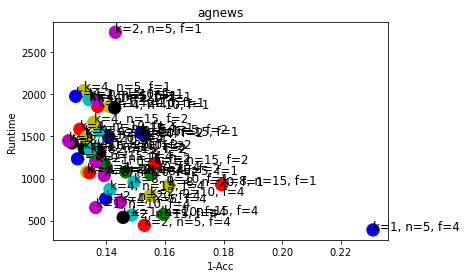

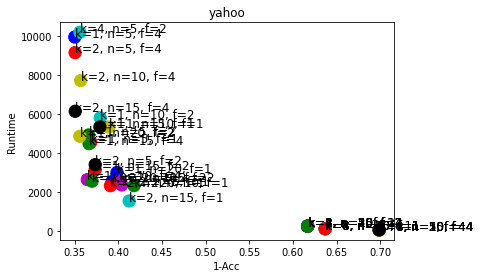

In [6]:
c=0
for dataset in datasets:
    fig = plt.figure()
    plt.title(f"{dataset}")
    plt.xlabel("1-Acc")
    plt.ylabel("Runtime")
    plt.scatter(1- np.array(acc_list[dataset]), np.array(runtime_list[dataset]),s=150,color=colors[:len(acc_list[dataset])])
    for idx in range(len(acc_list[dataset])):
        plt.text(1-acc_list[dataset][idx], runtime_list[dataset][idx], labels[idx], fontsize=12)
    plt.savefig(os.path.join(output_fig_path, f"c{c}.pdf"))
    c=c+1

/Users/cdq/opt/anaconda3/envs/fednlp/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/Users/cdq/opt/anaconda3/envs/fednlp/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/Users/cdq/opt/anaconda3/envs/fednlp/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in true_divide


/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/yahoo/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_4_conver_0_limit_0_fedpet_64_32_roberta-base_5_1.log not exists
/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/yahoo/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_4_conver_0_limit_0_fedpet_64_32_roberta-base_5_2.log not exists
/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/yahoo/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_4_conver_0_limit_0_fedpet_64_32_roberta-base_10_1.log not exists
/Users/cdq/Desktop/opensource/FedPrompt/data/log/pacing-11.01/yahoo/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_4_conver_0_limit_0_fedpet_64_32_roberta-base_10_2.log not exists


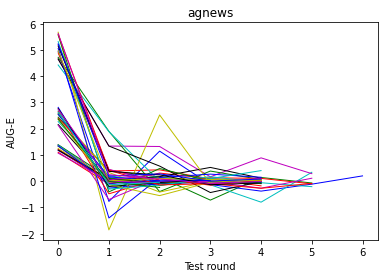

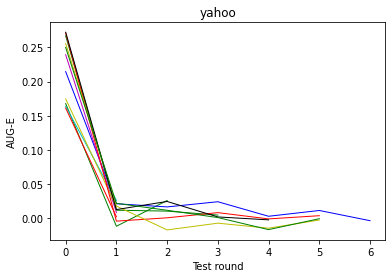

In [8]:
# time to accuracy  
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}    
trial = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}    
test_round = 5
for dataset in datasets:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = []
    labels = []
    for k in k_list:
        for n in n_list:
            for f in f_list:
                filenames.append(f"new_all_aug_{k}_conver_0_limit_0_fedpet_{train_data[dataset]}_32_roberta-base_{n}_{f}.log")
                labels.append(f"k={k}, n={n}, f={f}")
    
    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Test round")
    plt.ylabel("AUG-E")
    # plt.ylim(-0.1,0.2)
    for filename in filenames:

        log_path = os.path.join(log_root_path, filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        train_delta = []
        infer_delta = []
        acc_delta = []
        acc_tmp = 0

        
        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]

                train_samples = list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]
                infer_samples = list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]
                
                # TX2: train, 1s/sample, infer, 0.5s/sample.
                train_time = np.max(train_samples) * train_latency_list["tx2+bitfit"] if len(train_samples) > 0 else 0
                infer_time = np.max(infer_samples) * infer_latency_list["tx2+bitfit"] if len(infer_samples) > 0 else 0

                train_delta.append(train_time)
                infer_delta.append(infer_time)

            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc
                acc_delta.append(acc - acc_tmp)
                acc_tmp = acc
        
        
        infer_delta = [np.sum(np.array(infer_delta)) / len(infer_delta)] * len(infer_delta) # divide infer time into even time periods
        iter = len(df.index)
        
        # show_iter = 20
        show_iter = min(len(np.array(train_delta)), len(np.array(infer_delta)), len(np.array(acc_delta))) # make sure the length of three lists are the same

        train_gradient = np.array(acc_delta[:show_iter]) / np.array(train_delta[:show_iter])
        infer_gradient = np.array(acc_delta[:show_iter]) / np.array(infer_delta[:show_iter])

        curve = 100*np.array(acc_delta)[:show_iter] / (np.array(train_delta[:show_iter]) + np.array(infer_delta[:show_iter]))

        flag = 0
        curve_average = []
        tmp = 0
        for i in range(show_iter):
            if flag == test_round:
                curve_average.append(tmp)
                flag = 0
                tmp = 0
                continue
            else:
                tmp = tmp + curve[i]
                flag = flag + 1
        plt.plot(range(len(curve_average)), curve_average, label=labels[filenames.index(filename)], color=colors[filenames.index(filename)], linewidth=1)
    
    fig.savefig(os.path.join(output_fig_path, f"d{t}.pdf"))
    t = t+1

In [21]:
trial

{'agnews': [], 'mnli': [], 'yahoo': [], 'yelp-full': []}